## Load library

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy import stats
from scipy.signal import find_peaks

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(1)

Using TensorFlow backend.


## Data preprocessing

In [2]:
data = pd.read_csv('creditcard.csv')
data = data.drop(columns=['Time'])
# data = data.sample(frac = 0.1 ,random_state=1)
print(data.isnull().values.any())

data

False


V1         V2        V3        V4        V5        V6  \
0       -1.359807  -0.072781  2.536347  1.378155 -0.338321  0.462388   
1        1.191857   0.266151  0.166480  0.448154  0.060018 -0.082361   
2       -1.358354  -1.340163  1.773209  0.379780 -0.503198  1.800499   
3       -0.966272  -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4       -1.158233   0.877737  1.548718  0.403034 -0.407193  0.095921   
...           ...        ...       ...       ...       ...       ...   
284802 -11.881118  10.071785 -9.834783 -2.066656 -5.364473 -2.606837   
284803  -0.732789  -0.055080  2.035030 -0.738589  0.868229  1.058415   
284804   1.919565  -0.301254 -3.249640 -0.557828  2.630515  3.031260   
284805  -0.240440   0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  -0.533413  -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10  ...       V21       V22  \
0       0.239599  0.098698  0.363787  0.090794  ... -0.018307  0.277838   
1      -0.078803  0.085102 -0.255425 -0.166974  ... -0.225775 -0.638672   
2       0.791461  0.247676 -1.514654  0.207643  ...  0.247998  0.771679   
3       0.237609  0.377436 -1.387024 -0.054952  ... -0.108300  0.005274   
4       0.592941 -0.270533  0.817739  0.753074  ... -0.009431  0.798278   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -4.918215  7.305334  1.914428  4.356170  ...  0.213454  0.111864   
284803  0.024330  0.294869  0.584800 -0.975926  ...  0.214205  0.924384   
284804 -0.296827  0.708417  0.432454 -0.484782  ...  0.232045  0.578229   
284805 -0.686180  0.679145  0.392087 -0.399126  ...  0.265245  0.800049   
284806  1.577006 -0.414650  0.486180 -0.915427  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28  Amount  \
0      -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62   
1       0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69   
2       0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  378.66   
3      -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458  123.50   
4      -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   69.99   
...          ...       ...       ...       ...       ...       ...     ...   
284802  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731    0.77   
284803  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527   24.79   
284804 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561   67.88   
284805 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533   10.00   
284806  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649  217.00   

        Class  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
284802      0  
284803      0  
284804      0  
284805      0  
284806      0  

[284807 rows x 30 columns]

In [3]:
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
data_scale = preprocessing.MinMaxScaler().fit_transform(data.values)
y = data["Class"].values
X_normal, X_fraud = data_scale[y == 0], data_scale[y == 1]
Y_normal, Y_fraud = np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])

In [5]:
outlier_fraction = len(Y_fraud)/float(len(Y_normal))
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Y_fraud)))
print("Valid Cases : {}".format(len(Y_normal)))

0.0017304750013189597
Fraud Cases : 492
Valid Cases : 284315


In [6]:
# X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(data_scale, y, test_size=0.2)

X_train_normal, X_test_normal, Y_train_normal, Y_test_normal = train_test_split(X_normal, Y_normal, test_size=0.2)
X_train_fraud, X_test_fraud, Y_train_fraud, Y_test_fraud = train_test_split(X_fraud, Y_fraud, test_size=0.2)

X_train_all = np.append(X_train_normal, X_train_fraud, axis = 0)
X_test_all = np.append(X_test_normal, X_test_fraud, axis = 0)
Y_train_all = np.append(Y_train_normal, Y_train_fraud)
Y_test_all = np.append(Y_test_normal, Y_test_fraud)

# all fraud with test normal
X_test_afwn = np.append(X_test_normal, X_fraud, axis = 0)
Y_test_afwn = np.append(Y_test_normal, Y_fraud)

## Isolation forest (unsupervised)

In [7]:
clf = IsolationForest(contamination=outlier_fraction)
clf.fit(X_train_all)

IsolationForest(contamination=0.0017304750013189597)

In [8]:
y_pred = clf.predict(X_test_all)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(classification_report(Y_test_all,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.22      0.19      0.20        99

    accuracy                           1.00     56962
   macro avg       0.61      0.60      0.60     56962
weighted avg       1.00      1.00      1.00     56962



## Random forest (supervised)

In [9]:
clf = RandomForestClassifier()
clf.fit(X_train_all, Y_train_all)

RandomForestClassifier()

In [10]:
y_pred = clf.predict(X_test_all)
print(classification_report(Y_test_all,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      1.00      1.00        99

    accuracy                           1.00     56962
   macro avg       1.00      1.00      1.00     56962
weighted avg       1.00      1.00      1.00     56962



## One-class SVM (semi-supervised)

In [ ]:
clf = OneClassSVM(kernel='rbf')
clf.fit(X_normal)

In [ ]:
y_pred = clf.predict(X_test_all)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(classification_report(Y_test_all,y_pred))

## One-class Autoencoder
1. Semi-supervised: using threshold
1. Hybrid (semi-supervised & supervised): encoder + classifier

In [11]:
input_layer = Input(shape=(X_train_normal.shape[1],))

## encoding part
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

## decoding part
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)

## output layer
output_layer = Dense(X_train_normal.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [13]:
autoencoder.fit(X_train_normal, X_train_normal, epochs=10, shuffle=True)

Epoch 1/10
227452/227452 [==============================] - 23s 100us/step - loss: 1.0072e-04
Epoch 2/10
227452/227452 [==============================] - 26s 114us/step - loss: 7.9183e-05
Epoch 3/10
227452/227452 [==============================] - 25s 108us/step - loss: 7.4135e-05
Epoch 4/10
227452/227452 [==============================] - 22s 97us/step - loss: 7.0935e-05
Epoch 5/10
227452/227452 [==============================] - 24s 108us/step - loss: 6.7843e-05
Epoch 6/10
227452/227452 [==============================] - 28s 124us/step - loss: 6.5598e-05
Epoch 7/10
227452/227452 [==============================] - 21s 92us/step - loss: 6.3574e-05
Epoch 8/10
227452/227452 [==============================] - 24s 107us/step - loss: 5.4488e-05
Epoch 9/10
227452/227452 [==============================] - 26s 116us/step - loss: 4.7155e-05
Epoch 10/10
227452/227452 [==============================] - 29s 128us/step - loss: 4.4593e-05


In [14]:
def d2_visualize(x1, y1, name="graph.png", method="pca"):
    tsne = TSNE(n_components=2, random_state=1)
    pca = PCA(n_components=2, random_state=1)
    
    
    if method == "tsne":
        X_t = tsne.fit_transform(x1)
    elif method == "pca":
        X_t = pca.fit_transform(x1)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    

In [15]:
encoder = Sequential()
encoder.add(autoencoder.layers[0])
encoder.add(autoencoder.layers[1])
encoder.add(autoencoder.layers[2])

train_all_rep = encoder.predict(X_train_all)
test_all_rep = encoder.predict(X_test_all)
test_afwn_rep = encoder.predict(X_test_afwn)

In [ ]:
# tsne_plot(test_afwn_rep, Y_test_afwn, "latent_representation.png")

In [20]:
clf = LogisticRegression().fit(train_all_rep, Y_train_all)
pred_y = clf.predict(test_all_rep)
print (classification_report(Y_test_all, pred_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       0.99      0.94      0.96        99

    accuracy                           1.00     56962
   macro avg       0.99      0.97      0.98     56962
weighted avg       1.00      1.00      1.00     56962



In [21]:
pred = autoencoder.predict(X_test_afwn)
mse = np.mean(np.power(X_test_afwn - pred, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test_afwn})

# pred = autoencoder.predict(X_test_afwn)
# mse = mean_squared_error(X_test_afwn, pred)
# error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': Y_test_afwn})

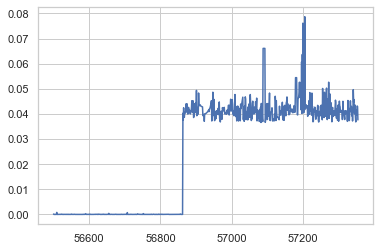

In [28]:
error_df.iloc[56500:,0].plot()

In [29]:
true_error = error_df[error_df['true_class']==0]
sorted_error = sorted(true_error['reconstruction_error'].values, reverse=True)
peaks = sorted_error[:20]
# peak_id, _ = find_peaks(true_error)
# peak_error = []
# for i in peak_id:
#     peak_error.append(true_error[i])

In [34]:
threshold_fixed = sorted_error[0] # np.mean(peaks)
threshold_fixed

0.009948925486233513

In [35]:
pred_y = [1 if e >= threshold_fixed else 0 for e in error_df.reconstruction_error.values]
print(classification_report(error_df.true_class, pred_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      1.00      1.00       492

    accuracy                           1.00     57355
   macro avg       1.00      1.00      1.00     57355
weighted avg       1.00      1.00      1.00     57355

